# Pytorch Workflow

### An end-to-end pytorch worflow

In [1]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [2]:
import torch
from torch import nn ## nn contains all of pytorchs's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np
# check pytorch version
torch.__version__

'1.11.0+cpu'

## 1. Data Preparing and Loading

### Let's create some *know* data using linear regression formula. We'll use a linear regression formula to make a straight line with *know* **parameters**

In [3]:
### Create *know* parameters
weight = 0.7
bias = 0.3

# create
start = 0
end = 1
step =0.02
X = torch.arange(start,end, step).unsqueeze(dim=1)
y = weight * X + bias

In [4]:
X[:10], y[:10], X.shape, y.shape

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 torch.Size([50, 1]),
 torch.Size([50, 1]))

### Splitting data into training and test set

In [5]:
len(X), len(y)

(50, 50)

In [6]:
# create a train-test split
train_split = int(0.8 * len(X))
train_split

40

In [7]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [8]:
len(X_train), len(X_test)

(40, 10)

## Plot predictions

In [9]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_lables=y_test,
                     predictions=None):
    """
    Plots training data, test data and compare predictions
    """
    plt.figure(figsize=(10,7))
    
    # plot training data
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
    
    # plot testing data
    plt.scatter(test_data, test_lables, c="g", s=4, label="Testing Data")
    
    # are there predictions?
    if predictions is not None:
        # plot the predictions if they exists
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    # show legends
    plt.legend(prop={"size": 14})

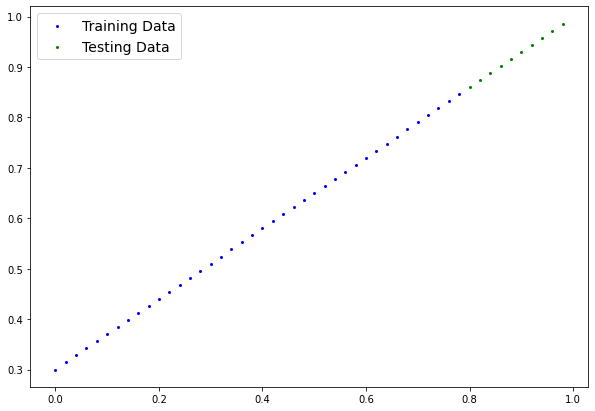

In [10]:
plot_predictions()

# Build Model

Our first pytorch model - Linear Regression

### Linear regression Model class

In [11]:
class LinearRegressionModel(nn.Module): # almost everything in Pytorch inherits from nn.Module
    
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    # forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # "x"is a input data
        return self.weight * x + self.bias # this is the linear regression formula

### Pytorch model building essentials

* torch.nn - contains all the building blocks for computational graphs ( a Neural Network can be consideted as computational graphs)
* torch.nn.Parameter - what parameters should our model try and learn - Often a pytorch layer from torch.nn will try and set this for us
* torch.nn.Module - The base class for all neural network modules , if you subclass this, you should override the *forward* method
* torch.optim - This is where where the optimizers in Pytorch live, will help with gradient descent
* def forward() - All nn.Module subclassses require you to overwrite forward(), this methods defines what happens in forward computation

### Checking the contents of our pytorch model

Now that we have created our model, let's check what is inside this model

Checkout model paarmerets using .parameters()

In [12]:
# create a random seed
torch.manual_seed(42)

# create an instance of our model
model_0 = LinearRegressionModel()

# checkout the paarmeters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
# List of named paarmeters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using the torch.inference_mode()

To check our model's pedictive power, let's see how well its predicts 'y_test' based on 'X_test'

When we pass our data through our model, its is going to run it through the 'forward()' method

In [14]:
# make predictions with model

with torch.inference_mode():
    y_preds = model_0(X_test)
    
# you can do something similar using torch.no_gard() but inference_mode is prefered
# with torch.no_grad():
#     y_pred = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

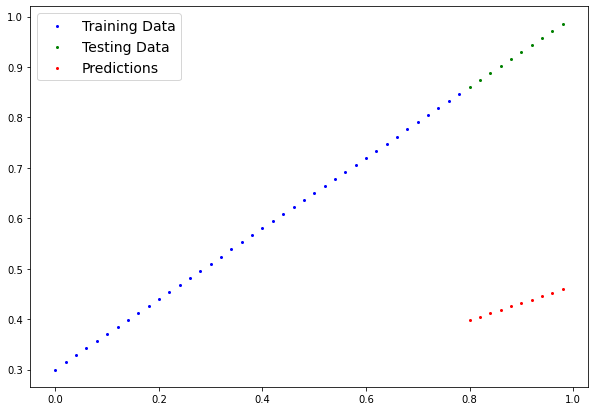

In [15]:
plot_predictions(predictions=y_preds)

## Training Model

## Things we need to train model:

* loss function
* optimizer
* training loop
* testing loop

### Loss Function: A way to measure how wrong your model predictions are. Lower are better

### Optimizer: Takes into account the loss of a model and adjusts the model's parameters to improve the loss function

In [16]:
## Setup a loss function
## Mean Absolute Error ( MAE or L1 Loss)

loss_fn = nn.L1Loss()

## Set up a optimizer ( Stochastic Gradient Descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.01)

## Building a Training and Testing Loop

Things we need a training loop

1. Loop through the data
2. Forward pass ( this involves data moving through model's forward()) - forward propogation - to make predictions
3. Calculate the loss ( compare the forward pass predictions to ground truth)
4. Optimizer zero grad
5. Loss backward - moves backward through the network to calculate the gardients of each of the parameters of our model with respect to loss function - back propagation
6. Optimizer step - use the optimizer to adjust the model parameters to try and improve the loss

In [17]:
torch.manual_seed(42)
# An epoch one loop through the complete data, one of the hyperparameter
epochs = 200

# Tracking important values
epoch_count = []
loss_values = []
test_loss_values = []

# Loop through the data
for epoch in range(epochs):
    # set the model to training model
    model_0.train() # train mode in pytorch sets all the parameters that requires gardient to require_gradients=True
    
    # 1. Forward method
    y_pred = model_0(X_train)
    
    #2. Calculate Loss
    loss = loss_fn(y_pred, y_train)
    
    #3. Optimizer zero grad
    optimizer.zero_grad()
    
    #4.Perform back propagation
    loss.backward()
    
    #5. Perform gardient descent
    optimizer.step() # be default how the optimizer change will accumulate through the loop.. so we have to zero them in step 3
    
    
    # Testing
    model_0.eval() # turns-off dfferent settings ( including dropout, batch-norm) not needed for testing
    with torch.inference_mode(): # turns off gradient tracking and couple of other things behind the scenes
        # 1. forward pass
        test_pred = model_0(X_test)
        
        # 2. calculate test loss
        test_loss = loss_fn(test_pred, y_test)
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch:{epoch} | Loss:{loss} | Test Loss:{test_loss}")
        
        # print model state
        print(model_0.state_dict())

Epoch:0 | Loss:0.31288138031959534 | Test Loss:0.48106518387794495
OrderedDict([('weight', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch:10 | Loss:0.1976713240146637 | Test Loss:0.3463551998138428
OrderedDict([('weight', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch:20 | Loss:0.08908725529909134 | Test Loss:0.21729660034179688
OrderedDict([('weight', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch:30 | Loss:0.053148526698350906 | Test Loss:0.14464017748832703
OrderedDict([('weight', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch:40 | Loss:0.04543796554207802 | Test Loss:0.11360953003168106
OrderedDict([('weight', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch:50 | Loss:0.04167863354086876 | Test Loss:0.09919948130846024
OrderedDict([('weight', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch:60 | Loss:0.03818932920694351 | Test Loss:0.08886633068323135
OrderedDict([('weight', tensor([0.5116])), ('bias', tensor([0.3788]))])
Epoch:70 | Loss:0.0347

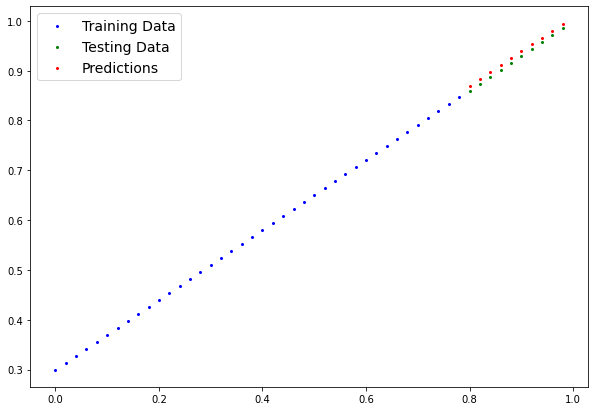

In [18]:
# make predictions
with torch.inference_mode():
    y_pred = model_0(X_test)
    
plot_predictions(predictions=y_pred)

## plot the loss curves

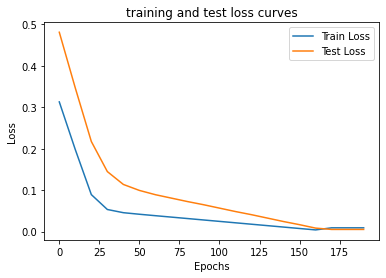

In [19]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test Loss")
plt.title("training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

# Saving and Loading a Model in Pytorch

There are three main methods for saving and loading a model

1. `torch.save()` --> allows us to save a PyTorch's object in python's pickle format
2. `torch.load()` --> allows us to load a saved PyTorch's object
3. `torch.nn.Module.load_state_dict()` --> this allows us to load a model's saved state dict

## Saving a model

In [20]:
from pathlib import Path

# Create Models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create a model save path
MODEL_NAME = "01_pytorch_worklow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save model dict
print(f"Saving Model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving Model to : models/01_pytorch_worklow_model_0.pth


In [21]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1063 Sep 14 08:33 01_pytorch_worklow_model_0.pth


## Loading a Model

Since we saved our model's `state_dict()` rather than the entire model, we will create a new instance of our model class and load the saved state_dict into that

In [22]:
# create a new instance of our model
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict and update the new instance
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [23]:
# check if the model is loaded correctly
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [24]:
# Make some predictions
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
    
loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [25]:
# Compare loaded model preds with original model preds
y_pred == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# 6 . Putting Eveything Together

In [26]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# check pytorch version
torch.__version__

'1.11.0+cpu'

## 6.1 Create device agnostic code.

This means if we have got access to a GPU, our code will use it ( for potentially faster computing). If No GPU is available, it will fall back to CPU

In [27]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## 6.2 Data

In [28]:
# create some data using the linear regression formula of y = weight * features + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

# split the data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split] 
X_test, y_test = X[train_split:], y[train_split:]

In [29]:
# Plot predictions
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_lables=y_test,
                     predictions=None):
    """
    Plots training data, test data and compare predictions
    """
    plt.figure(figsize=(10,7))
    
    # plot training data
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
    
    # plot testing data
    plt.scatter(test_data, test_lables, c="g", s=4, label="Testing Data")
    
    # are there predictions?
    if predictions is not None:
        # plot the predictions if they exists
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    # show legends
    plt.legend(prop={"size": 14})

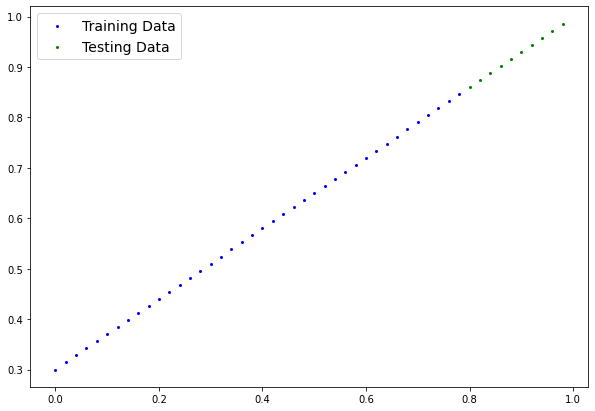

In [30]:
plot_predictions(X_train, y_train, X_test, y_test)

## 6.3 Build a Linear Model

In [31]:
# Create a Linear Model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
    
    def __init__(self):
        super().__init__()
        # use nn.Linear() for creating the model parameters / also called linear transformation, probing layer, fully_coonected layer, dense layer
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
# set the manual seed for reproducbility
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

## 6.4  Use the target device

In [32]:
# check the model's current device
next(model_1.parameters()).device

device(type='cpu')

In [33]:
# set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

## 6.5 Train Model

In [34]:
# Setup Loss Function
loss_fn = nn.L1Loss() # same as MAE

# Setup Optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr=0.01)

# Training Loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    
    model_1.train()
    
    # 1. Forward Pass
    y_pred = model_1(X_train)
    
    # 2. Calculate Loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Perform Backpropogation
    loss.backward()
    
    # 5. Optimize the weights
    optimizer.step()
    
    
    ## Testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)
        
    
    # print stuffs
    if epoch % 10 == 0:
        print(f"Epoch:{epoch} | Loss:{loss} | Test Loss:{test_loss}")

Epoch:0 | Loss:0.5551779866218567 | Test Loss:0.5739762187004089
Epoch:10 | Loss:0.4399680495262146 | Test Loss:0.4392663538455963
Epoch:20 | Loss:0.3247582018375397 | Test Loss:0.30455657839775085
Epoch:30 | Loss:0.20954827964305878 | Test Loss:0.16984674334526062
Epoch:40 | Loss:0.09433844685554504 | Test Loss:0.03513689711689949
Epoch:50 | Loss:0.023886386305093765 | Test Loss:0.04784906655550003
Epoch:60 | Loss:0.0199567973613739 | Test Loss:0.04580312222242355
Epoch:70 | Loss:0.016517987474799156 | Test Loss:0.0375305712223053
Epoch:80 | Loss:0.013089170679450035 | Test Loss:0.029944902285933495
Epoch:90 | Loss:0.009653178043663502 | Test Loss:0.02167237363755703
Epoch:100 | Loss:0.006215679459273815 | Test Loss:0.014086711220443249
Epoch:110 | Loss:0.002787243574857712 | Test Loss:0.005814164876937866
Epoch:120 | Loss:0.0012645035749301314 | Test Loss:0.013801807537674904
Epoch:130 | Loss:0.0012645035749301314 | Test Loss:0.013801807537674904
Epoch:140 | Loss:0.001264503574930131

In [35]:
# Check the state dict of the trained model
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

## 6.6 Making and Evaluating Predictions

In [36]:
# Turn the model in the eval mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_pred = model_1(X_test)

## for plotting we will need to bring our data from cuda ( if it was cuda) to cpu as matplotlib uses numpy and list and they work only on CPU

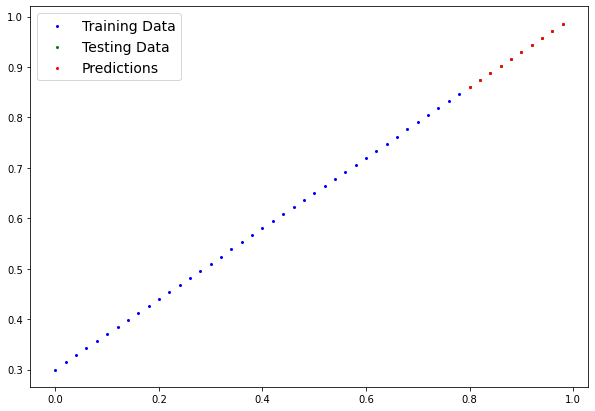

In [37]:
plot_predictions(predictions=y_pred.cpu())

## 6.6 Saving and Loading Model

In [38]:
from pathlib import Path

# Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Model Save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to : models/01_pytorch_workflow_model_1.pth


In [39]:
## Load a Model

# create a new instance
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [40]:
next(model_1.parameters()).device

device(type='cpu')

In [41]:
## Evaluate Loaded Model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
    
y_pred == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])